In [1]:
import anndata
import sys

import sys

from scGCO import *
import matplotlib.pyplot as plt
import numpy as np

D:\anaconda3\envs\scgco\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\anaconda3\envs\scgco\lib\site-packages\pysal\lib\weights\util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')
D:\anaconda3\envs\scgco\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
adata = anndata.read_h5ad("../data/Starmap.h5ad")

In [3]:
def read_spatial_raw_data(counts,
                            num_exp_genes=0.01, num_exp_spots=0.01, min_expression=1,
                            drop= False):
    
    '''
    Read raw data and returns pandas data frame of spatial gene express
    and numpy ndarray for single cell location coordinates; 
    Meanwhile processing raw data.
    
    :param file: csv file for spatial gene expression; 
    :rtype: coord (spatial coordinates) shape (n, 2); data: shape (n, m); 
    '''
    print('raw data dim: {}'.format(counts.shape))
    
    # filter all empty cells/spots
    counts.fillna(0)
    counts = counts[(counts == 0).sum(axis = 1) < counts.shape[1]]

    num_spots = len(counts.index)
    num_genes = len(counts.columns)
    min_genes_spot_exp = round((counts != 0).sum(axis=1).quantile(num_exp_genes))
    print("Number of expressed genes a spot must have to be kept " \
    "({}% of total expressed genes) {}".format(num_exp_genes, min_genes_spot_exp))
    
    if counts.shape[0] > 1000:   # too many cells/spots
        drop = True
    else:
        drop = drop
        
    if drop:
        counts = counts[(counts != 0).sum(axis=1) >= min_genes_spot_exp]
        noiseInd =[]
    else:
        mark_points = np.where((counts != 0).sum(axis=1) < min_genes_spot_exp)[0]
        print("Marked {} spots".format(len(mark_points)))
        if len(mark_points)>0:
            noiseInd = [counts.shape[0]-1-i for i in range(len(mark_points))]
            temp = [val.split('x') for val in counts.index.values]
            coord = np.array([[float(a[0]), float(a[1])] for a in temp])

            similar_points=np.argsort(cdist(coord[mark_points,:],coord),axis=1)[:,1]
            for i,j in zip(mark_points,similar_points):
                counts.iloc[i,:]=counts.iloc[j,:]

            mark_counts=counts.iloc[mark_points,:]
            dropped_counts = counts.drop(counts.index[mark_points])
            counts=pd.concat([dropped_counts,mark_counts])       
        else:
            counts = counts
            noiseInd =[] 
    
    # Spots are columns and genes are rows
    counts = counts.transpose()
    # Remove noisy genes
    min_features_gene = round(len(counts.columns) * num_exp_spots) 
    print("Removing genes that are expressed in less than {} " \
    "spots with a count of at least {}".format(min_features_gene, min_expression))
    counts = counts[(counts == 0).sum(axis=1) < counts.shape[1]]
    counts = counts[(counts >= min_expression).sum(axis=1) >= min_features_gene]
    print("Dropped {} genes".format(num_genes - len(counts.index)))

    data=counts.transpose()
    
    # recheck all empty cells/spots after delect low expression genes. 20211119 coco
    data = data[(data==0).sum(axis =1) < data.shape[1]]

    return data, noiseInd

In [4]:
data, _ = read_spatial_raw_data(adata.to_df())

raw data dim: (1207, 1020)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 107
Removing genes that are expressed in less than 12 spots with a count of at least 1
Dropped 0 genes


In [5]:
data_norm = normalize_count_cellranger(data)

D:\anaconda3\envs\scgco\lib\site-packages\scGCO\Preprocessing.py:170: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data = pd.DataFrame(data.values/normalizing_factor[:,np.newaxis], columns=data.columns, index=data.index)


In [6]:
data_norm

Gene,1110008F13Rik,1110008P14Rik,1700019D03Rik,1700086L19Rik,2810468N07Rik,2900055J20Rik,2900092D14Rik,3110035E14Rik,3632451O06Rik,6330403K07Rik,...,Zcchc12,Zdhhc24,Zfand6,Zfp57,Zfp637,Zfp975,Zmat4,Zmym1,Znhit3,Znrd1
Cell_00008,0.862618,1.318741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.862618,0.862618,1.318741,0.000000,0.000000,0.862618,0.000000,0.000000
Cell_00009,0.000000,0.000000,0.000000,0.585804,0.585804,0.952766,0.000000,0.585804,0.585804,0.000000,...,0.000000,0.952766,0.000000,0.000000,1.220625,0.585804,0.585804,0.000000,0.000000,0.000000
Cell_00012,0.662255,0.000000,0.000000,1.057206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.662255,1.057206,0.000000,0.000000,0.662255,0.000000,0.000000,0.000000,0.000000,0.000000
Cell_00014,0.000000,0.000000,0.000000,0.000000,0.000000,0.905819,0.000000,0.000000,0.000000,0.905819,...,0.000000,0.000000,0.000000,0.905819,1.690442,0.000000,0.000000,0.905819,0.000000,0.000000
Cell_00015,0.000000,1.050041,0.000000,0.656942,0.000000,0.000000,0.000000,0.656942,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.331482,0.000000,1.050041,0.000000,0.656942,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_01381,0.541320,0.000000,0.541320,0.000000,0.541320,0.541320,0.000000,1.354054,0.000000,0.000000,...,0.541320,0.000000,0.541320,0.541320,0.541320,0.000000,0.000000,0.000000,0.000000,0.000000
Cell_01382,0.816865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.800648,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.149476,0.000000,0.000000,0.000000,0.000000,0.816865
Cell_01384,0.000000,1.152411,0.000000,0.000000,0.000000,0.733765,0.000000,1.446619,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.152411,0.000000,0.733765,0.000000,0.000000,0.000000
Cell_01386,0.000000,0.000000,1.264668,0.000000,0.000000,1.264668,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.820202,0.000000,0.820202,0.000000,0.000000,0.820202,0.000000,0.000000


In [7]:
adata = adata[data_norm.index,]

In [8]:
locs = adata.obsm['spatial'].copy()

Text(0.5, 1.0, 'CellGraph')

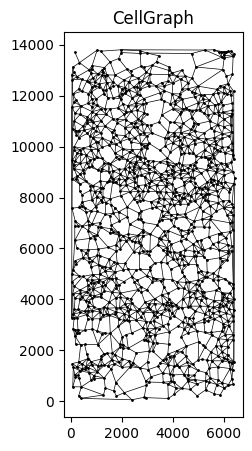

In [9]:
fig, ax= plt.subplots(1,1,figsize=(5,5)) #, dpi=300)
ax.set_aspect('equal')

exp= data_norm.iloc[:,0].values
cellGraph =create_graph_with_weight(locs, exp)
ax.scatter(locs[:,0], locs[:,1], s=1, color='black')
for i in np.arange(cellGraph.shape[0]):
    x = (locs[int(cellGraph[i,0]), 0], locs[int(cellGraph[i,1]), 0]) 
    y = (locs[int(cellGraph[i,0]), 1], locs[int(cellGraph[i,1]), 1])     
    ax.plot(x, y, color='black', linewidth=0.5)
    
plt.title('CellGraph')

In [10]:
gmmDict= multiGMM(data_norm)

scGCO used 21 out of 36 cores


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.20it/s]


In [11]:
result_df= identify_spatial_genes(locs, data_norm, cellGraph,gmmDict)

scGCO used 18 out of 36 cores


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.25it/s]


In [12]:
fdr05_df = result_df.loc[result_df.fdr<0.05].sort_values(by=["fdr"])

In [13]:
fdr05_df

,p_value,fdr,smooth_factor,nodes,model,model_labels,label_cell_1,label_cell_2,label_cell_3,label_cell_4,...,label_cell_1189,label_cell_1190,label_cell_1191,label_cell_1192,label_cell_1193,label_cell_1194,label_cell_1195,label_cell_1196,label_cell_1197,label_cell_1198
Mobp,"[7.511844523314206e-05, 1e-29, 0.1461198385469...",0.0,30,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1...",gmm,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Mbp,"[1.3315608319461143e-05, 1e-29, 0.121979897939...",0.0,30,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1...",gmm,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Lamp5,"[1.956522246918885e-05, 1e-29, 3.0318371323098...",0.0,10,"[[0, 1, 3, 5, 7, 8, 9, 10, 14, 15, 16, 17, 18,...",gmm,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, ...",0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
Pcp4,"[1.7090920044438535e-07, 1e-29, 1, 1]",0.0,30,"[[1, 2, 6, 9, 10, 11, 12, 13, 14, 16, 17, 18, ...",otsu,"[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",1,0,0,1,...,0,1,0,1,0,1,1,0,0,0
Pcsk2,"[1e-29, 2.304150657536893e-18, 4.6381222251804...",0.0,10,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1...",otsu,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",1,1,1,1,...,1,0,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sox2ot,"[0.1782726178985142, 1.129508475145106e-06, 1,...",0.000017,10,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",gmm,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Slc17a7,"[0.05091356576994033, 4.2138265122957465e-06, ...",0.000062,30,"[[1, 2, 4, 6, 9, 10, 12, 14, 16, 17, 18, 20, 2...",gmm,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...",1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Tle4,"[0.3530052902726816, 5.3110742720489015e-06, 1...",0.000077,20,"[[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, ...",gmm,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
Ptgds,"[0.1852108149728283, 0.00010432356818878354, 1...",0.001499,30,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",gmm,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


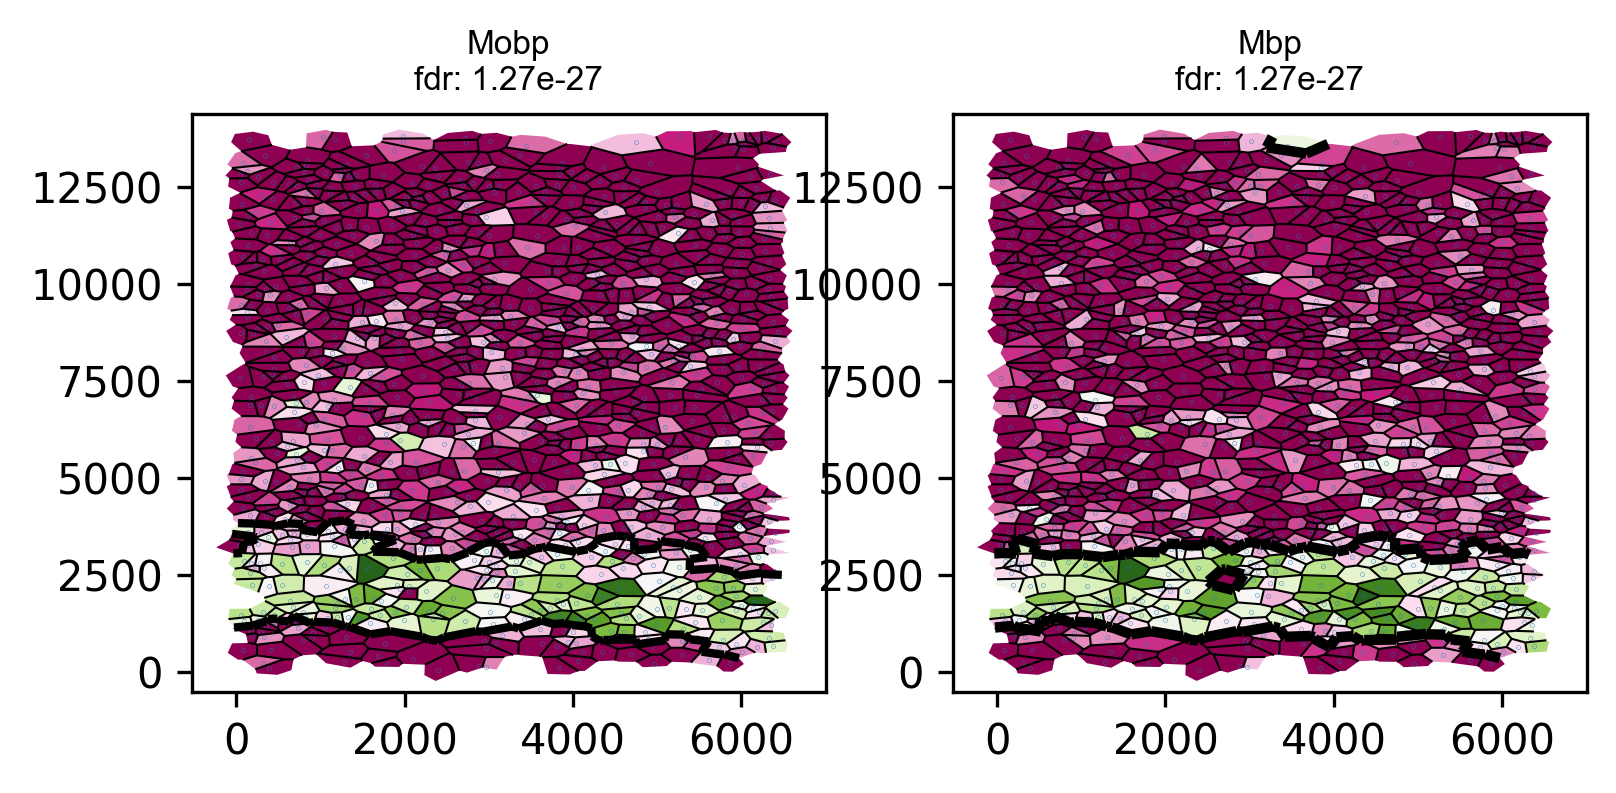

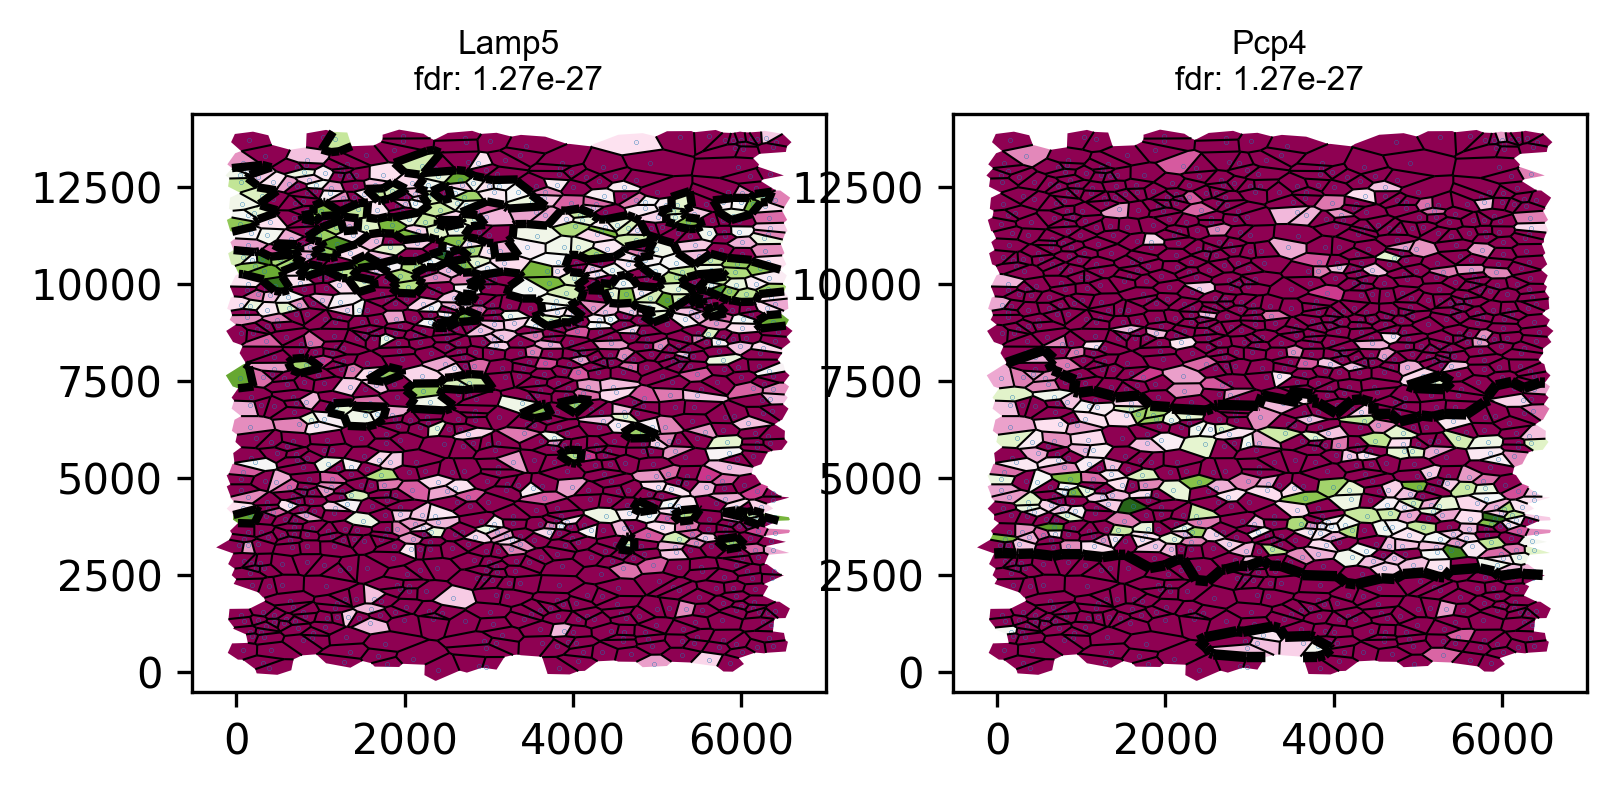

In [15]:
# visualize top genes
visualize_spatial_genes(fdr05_df.iloc[0:4,], locs, data_norm,cellGraph ,point_size=0.2)


In [ ]:
write_result_to_csv(result_df,"../data/result_df.csv")